# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [175]:
import re
from time import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import torch as tt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torchtext.data import Field, LabelField, TabularDataset, Iterator 
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

Загрузка данных  

In [3]:
STOPWORDS = stopwords.words('english')

In [3]:
df_master = pd.read_csv("imdb_master.csv", encoding='latin-1', index_col=0)

imdb_train = df_master[["review", "label"]][df_master.type.isin(['train'])].reset_index(drop=True)
imdb_test = df_master[["review", "label"]][df_master.type.isin(['test'])].reset_index(drop=True)

Я решил удалить объекты с меткой unsup, т.к. в тестовом подмножестве объектов с этой меткой нет

In [4]:
imdb_train = imdb_train[imdb_train.label != 'unsup']

In [7]:
imdb_train.shape, imdb_test.shape

((25000, 2), (25000, 2))

In [5]:
imdb_train.to_csv('imdb_train.csv', index=False)
imdb_test.to_csv('imdb_test.csv', index=False)

Подготовка данных с помощью `torchtext`

In [4]:
def tokenizer(x):
    tokens = []
    
    for w in x.split():
        token = re.sub('^[\W]*|[\W]*$', '', w)
        
        if token:
            tokens.append(token)
            
    return tokens


Возьмем в качестве фиксированной длины для всех предложений медиану длин по train подмножеству

In [9]:
np.median([len(tokenizer(x)) for x in imdb_train.review.values])

174.0

In [118]:
classes={
    'neg': 0,
    'pos': 1
}

TEXT = Field(
    sequential=True,
    fix_length=175,
    pad_first=False,
    batch_first=True, 
    eos_token='<eos>',
    lower=True,
    stop_words=STOPWORDS
)

TRAIN_LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])
TEST_LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])


train_dataset = TabularDataset(
    'imdb_train.csv',
     format='csv', 
     fields=[('review', TEXT), ('label', TRAIN_LABEL)], 
     skip_header=True
)


test_dataset = TabularDataset(
    'imdb_test.csv',
     format='csv', 
     fields=[('review', TEXT), ('label', TEST_LABEL)], 
     skip_header=True
)

In [119]:
TEXT.build_vocab(train_dataset, min_freq=5, vectors='glove.6B.100d')

In [120]:
VECTORS = TEXT.vocab.vectors

In [121]:
TRAIN_LABEL.build_vocab(train_dataset)
TEST_LABEL.build_vocab(test_dataset)

NN функционал

Предварительно немного поэкспериментировав, стало видно, что модели очень быстро и сильно оверфитятся, что, впрочем, ожидаемо, учитывая соотношение кол-ва объектов в обуч. выборке и параметров в архитектурах с выучиванием / тюнингом эмбеддингов.  
Поэтому я решил использовать дропаут и пулинг-слой вне рамок бонусного пункта, а для регуляризации (дропаут) и хоть и небольшого, но уменьшения числа параметров моделей (глобал макс. пулинг).  
В итоге для всех дальнейших экспериментов я использовал фиксированную архитектуру с одним сверточным слоем, следующим за ним дропаутом и глобальным макс. пулингом.

In [166]:
class CNN(tt.nn.Module):
        
    def __init__(
        self,
        vocab_size,
        seq_len,
        embedding_size,
        n_filters,
        kernel_size,
        stride=1,
        vectors=None,
        freeze_embeddings=True,
    ):
        super(CNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embedding_size = embedding_size
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.vectors = vectors
        self.freeze_embeddings = freeze_embeddings
        
        self.conv_dim = (self.seq_len - self.kernel_size) // self.stride + 1
        self.flat_size = self.n_filters * self.conv_dim
        
        if self.vectors is not None:
            self.embeddings = tt.nn.Embedding.from_pretrained(self.vectors, freeze=self.freeze_embeddings)
            
        else:
            self.embeddings = tt.nn.Embedding(self.vocab_size, self.embedding_size)
            self.embeddings.requires_grad = not self.freeze_embeddings
        
        self.conv = tt.nn.Conv1d(
            in_channels=self.embedding_size,
            out_channels=self.n_filters,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=0
        )
        self.conv_drop = tt.nn.Dropout(0.15)
        
        self.pool = tt.nn.MaxPool1d(self.conv_dim)
        
        self.output_layer = tt.nn.Linear(self.n_filters, 2)
                
    def forward(self, x):
        x = self.embeddings(x)
        x = x.permute(0, 2, 1)
                
        x = self.conv(x)
        x = tt.nn.functional.relu(x)
        x = self.conv_drop(x)
        
        x = self.pool(x)
        x = x.view(-1, self.n_filters)
        
        x = self.output_layer(x)

        return x

In [158]:
def train(epochs, model, optimizer, train_iterator, val_iterator, scheduler=None, patience=5):    
    lr_history = []
    train_losses = []
    val_losses = []
    min_val_loss = np.inf
    n_no_improv_epochs = 0
    
    criterion = tt.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        c_train_losses = []
        c_val_losses = []
        
        st_time = time()
        
        for batch in train_iterator:
            optimizer.zero_grad()
            
            pred = model.forward(batch.review)
            train_loss = criterion(pred, batch.label)
            c_train_losses.append(train_loss.item())
            
            train_loss.backward()
            
            optimizer.step()
        
        c_train_loss = np.mean(c_train_losses)
        
        train_losses.append(c_train_loss)
        
        with tt.no_grad():
            for val_batch in val_iterator:
                val_pred = model.forward(val_batch.review)
                
                val_loss = criterion(val_pred, val_batch.label)
                c_val_losses.append(val_loss.item())
            
            c_val_loss = np.mean(c_val_losses)
            val_losses.append(c_val_loss)
            
        if c_val_loss < min_val_loss:
            min_val_loss = c_val_loss
            n_no_improv_epochs = 0
            
        elif n_no_improv_epochs < patience:
            n_no_improv_epochs += 1
            
        else:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        if scheduler is not None:
            scheduler.step()
        
        c_time = time() - st_time
        
        print(f'epoch: {epoch+1} \t train_loss: {c_train_loss:.4f} \t val_loss: {c_val_loss:.4f} \t time: {c_time:.2f} s.')
        
    return train_losses, val_losses, lr_history
        

In [107]:
def predict(model, test_iter):
    X = list(test_iter)[0]
    
    with tt.no_grad():
        pred = model.forward(X.review)
        
    pred = tt.nn.functional.softmax(pred, dim=1)
    
    return X.label.numpy(), pred.numpy()
    

In [108]:
def get_iterator(
    dataset,
    batch_size,
    train=True, 
    shuffle=True,
    repeat=False
):
    dataset_iter = Iterator(
        dataset,
        batch_size=batch_size,
        train=train,
        shuffle=shuffle,
        repeat=repeat,
        sort=False
    )
    
    return dataset_iter

In [ ]:
def plot_lr_history(lr_history, title='LR history'):
    plt.plot(range(len(lr_history)), lr_history, alpha=0.8)
    
    plt.xlabel('i-th epoch')
    plt.ylabel('Leraning rate')
    plt.title(title)
    

def plot_loss_curves(train_losses, val_losses, title='Loss curves'):
    plt.plot(range(len(train_losses)), train_losses, alpha=0.75, label='train loss')
    plt.plot(range(len(val_losses)), val_losses, alpha=0.75, label='val loss')
    
    plt.xlabel('i-th epoch')
    plt.ylabel('Loss')
    plt.title(title)
    
    plt.legend()
    

In [122]:
EPOCHS = 30
BATCH_SIZE = 128

В качестве валидационных данных возьмем 10% обуч. данных

In [123]:
train_split, val_split = train_dataset.split(split_ratio=0.9, stratified=True)

In [124]:
train_iter = get_iterator(train_split, BATCH_SIZE)

In [125]:
val_iter = get_iterator(val_split, BATCH_SIZE)

In [126]:
test_iter = get_iterator(test_dataset, len(test_dataset.examples), train=False)

Модель с замороженными GloVe эмбеддингами

In [180]:
model_glove_frozen = CNN(
    vocab_size=len(TEXT.vocab.itos),
    seq_len=175,
    embedding_size=100,
    n_filters=128,
    kernel_size=3,
    stride=1,
    vectors=VECTORS,
    freeze_embeddings=True
)

В качестве оптимизатора здесь и далее использовался adam.  
Стратегия снижения длины шага также едина на все эксперименты - домножение на 0.9 после каждых двух эпох (поверхностно настраивал эти гиперпараметры)

In [181]:
optimizer = tt.optim.Adam(model_glove_frozen.parameters())
scheduler = tt.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9)

In [182]:
%%time
train_losses, val_losses, lr_history = train(
    EPOCHS,
    model_glove_frozen,
    optimizer,
    train_iter,
    val_iter,
    scheduler=scheduler
)

epoch: 1 	 train_loss: 0.5125 	 val_loss: 0.4087 	 time: 25.03 s.
epoch: 2 	 train_loss: 0.3834 	 val_loss: 0.3749 	 time: 25.48 s.
epoch: 3 	 train_loss: 0.3345 	 val_loss: 0.3585 	 time: 24.36 s.
epoch: 4 	 train_loss: 0.2973 	 val_loss: 0.3512 	 time: 24.45 s.
epoch: 5 	 train_loss: 0.2694 	 val_loss: 0.3861 	 time: 24.56 s.
epoch: 6 	 train_loss: 0.2405 	 val_loss: 0.3500 	 time: 23.62 s.
epoch: 7 	 train_loss: 0.2163 	 val_loss: 0.3549 	 time: 23.92 s.
epoch: 8 	 train_loss: 0.1920 	 val_loss: 0.3585 	 time: 24.18 s.
epoch: 9 	 train_loss: 0.1756 	 val_loss: 0.3551 	 time: 24.40 s.
epoch: 10 	 train_loss: 0.1596 	 val_loss: 0.3544 	 time: 24.57 s.
epoch: 11 	 train_loss: 0.1450 	 val_loss: 0.3619 	 time: 23.73 s.
Early stopping at epoch 12
CPU times: user 13min 54s, sys: 11.5 s, total: 14min 6s
Wall time: 4min 52s


График длины шага в зависимости от номера эпохи

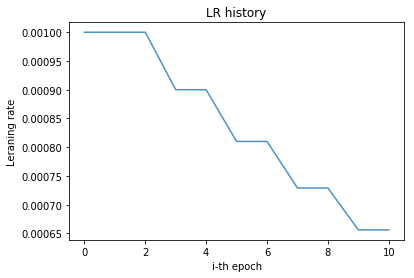

In [189]:
plot_lr_history(lr_history)

График значения ф-ии потерь на обуч. и валид. данных в зависимости от номера эпохи

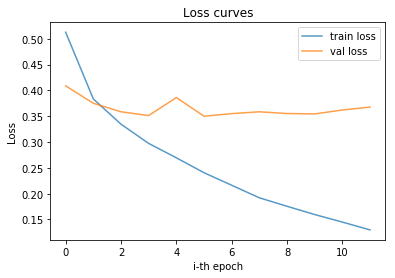

In [192]:
plot_loss_curves(train_losses, val_losses)

Модель, доучивающая GloVe эмбеддинги

In [193]:
model_glove = CNN(
    vocab_size=len(TEXT.vocab.itos),
    seq_len=175,
    embedding_size=100,
    n_filters=128,
    kernel_size=3,
    stride=1,
    vectors=VECTORS,
    freeze_embeddings=False
)

In [194]:
optimizer_glove = tt.optim.Adam(model_glove.parameters())
scheduler_glove = tt.optim.lr_scheduler.StepLR(optimizer_glove, 2, gamma=0.9)

In [195]:
%%time
train_losses_glove, val_losses_glove, lr_history_glove = train(
    EPOCHS,
    model_glove,
    optimizer_glove,
    train_iter,
    val_iter,
    scheduler=scheduler_glove
)

epoch: 1 	 train_loss: 0.4961 	 val_loss: 0.3752 	 time: 45.38 s.
epoch: 2 	 train_loss: 0.3070 	 val_loss: 0.3288 	 time: 45.27 s.
epoch: 3 	 train_loss: 0.2009 	 val_loss: 0.3094 	 time: 44.90 s.
epoch: 4 	 train_loss: 0.1077 	 val_loss: 0.3125 	 time: 44.94 s.
epoch: 5 	 train_loss: 0.0507 	 val_loss: 0.3225 	 time: 44.02 s.
epoch: 6 	 train_loss: 0.0225 	 val_loss: 0.3544 	 time: 45.83 s.
epoch: 7 	 train_loss: 0.0115 	 val_loss: 0.3773 	 time: 44.92 s.
epoch: 8 	 train_loss: 0.0066 	 val_loss: 0.3884 	 time: 45.98 s.
Early stopping at epoch 9
CPU times: user 19min 12s, sys: 17.1 s, total: 19min 30s
Wall time: 6min 46s


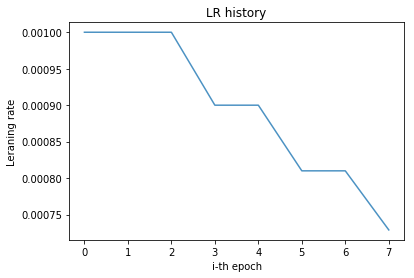

In [196]:
plot_lr_history(lr_history_glove)

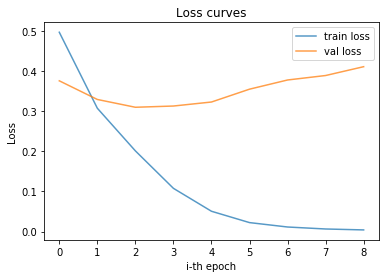

In [197]:
plot_loss_curves(train_losses_glove, val_losses_glove)

Модель, учащая эмбеддинги с нуля

In [198]:
model_learnt = CNN(
    vocab_size=len(TEXT.vocab.itos),
    seq_len=175,
    embedding_size=100,
    n_filters=128,
    kernel_size=3,
    stride=1,
    vectors=None,
    freeze_embeddings=False
)

In [199]:
optimizer_learnt = tt.optim.Adam(model_learnt.parameters())
scheduler_learnt = tt.optim.lr_scheduler.StepLR(optimizer_learnt, 2, gamma=0.9)

In [200]:
%%time
train_losses_learnt, val_losses_learnt, lr_history_learnt = train(
    EPOCHS,
    model_learnt,
    optimizer_learnt,
    train_iter,
    val_iter,
    scheduler=scheduler_learnt
)

epoch: 1 	 train_loss: 0.6088 	 val_loss: 0.5067 	 time: 45.68 s.
epoch: 2 	 train_loss: 0.4178 	 val_loss: 0.4336 	 time: 45.78 s.
epoch: 3 	 train_loss: 0.2985 	 val_loss: 0.4047 	 time: 45.63 s.
epoch: 4 	 train_loss: 0.1988 	 val_loss: 0.3854 	 time: 45.46 s.
epoch: 5 	 train_loss: 0.1251 	 val_loss: 0.3971 	 time: 47.89 s.
epoch: 6 	 train_loss: 0.0756 	 val_loss: 0.3933 	 time: 45.27 s.
epoch: 7 	 train_loss: 0.0467 	 val_loss: 0.4336 	 time: 47.01 s.
epoch: 8 	 train_loss: 0.0307 	 val_loss: 0.4168 	 time: 45.24 s.
epoch: 9 	 train_loss: 0.0219 	 val_loss: 0.4611 	 time: 45.05 s.
Early stopping at epoch 10
CPU times: user 21min 48s, sys: 19 s, total: 22min 7s
Wall time: 7min 40s


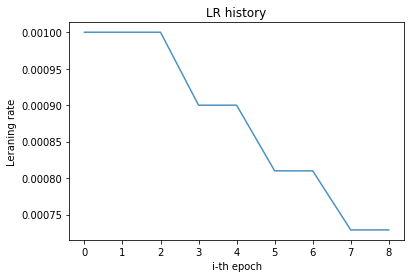

In [201]:
plot_lr_history(lr_history_learnt)

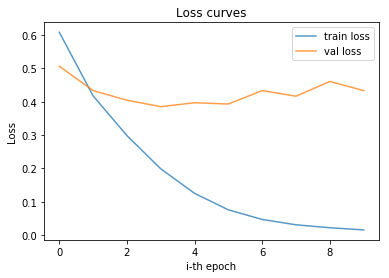

In [202]:
plot_loss_curves(train_losses_learnt, val_losses_learnt)

В целом по логам и графикам всех экспериментов видно, что модели начинают переобучаться приблизительно с 5-ой эпохи, что приводит к раннему "раннему" останову.  
Как мне кажется, подобное может быть обусловлено недостатком обучающих данных, ведущим к несоизмеримому соотношению между числом объектов на обучении и параметров модели.  
С другой стороны, вполне возможно, что и для текущей задачи и идентичных архитектур существует способ добиться более высокого качества.

Оценим качество моделей на тестовых данных

In [203]:
scores = {}

for model, model_name in zip([model_glove_frozen, model_glove, model_learnt], ['GloVe frozen', 'GloVe tuned', 'Learnt']):
    y_true, y_pred = predict(model_glove_frozen, test_iter)
    scores[model_name] = log_loss(y_true, y_pred)

Качество полученных моделей на тестовых данных

In [204]:
scores

{'GloVe frozen': 0.3801131587303763,
 'GloVe tuned': 0.3816655073283186,
 'Learnt': 0.3771532812326295}

Качество при случайном гадании

In [48]:
log_loss(y_true, [0.5 for _ in range(25000)])

0.6931471805599453

Кривая качества на тестовой выборке в зависимости от гиперпараметра - эмбеддингов

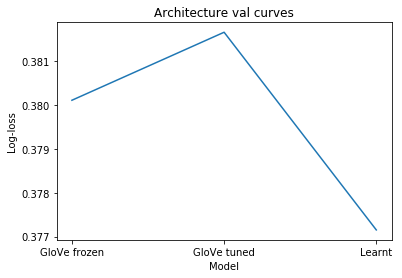

In [210]:
plt.plot(range(len(scores)), [v for k, v in scores.items()])
plt.xticks(range(len(scores)), [k for k, v in scores.items()])
plt.xlabel('Model')
plt.ylabel('Log-loss')
plt.title('Architecture val curves');

В итоге качество полученных моделей, по сути, идентично с небольшим перевесом выученных с нуля эмбеддингов над pre-trained GloVe